## 剪枝算法尝试

In [7]:
import numpy as np
import sys
import time

import os
import cv2
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
sys.path.append('../')
sys.path.append('../data/')
from resnet import resnet
from preact_resnet import PreActResNet18
from load_cifar import load_cifar
from load_olivetti import load_olivetti

In [8]:
# 函数们
def rbg_to_grayscale(images):
    return np.dot(images[..., :3], [0.299, 0.587, 0.114])

def reshape_data(X_train, y_train, X_test):
    # reshape train and subtract mean
    pixel_mean = np.mean(X_train, axis=0)
    X_train -= pixel_mean
    X_test -= pixel_mean
    X_train_flip = X_train[:, :, :, ::-1]
    X_train = np.concatenate((X_train, X_train_flip), axis=0)
    y_train = np.concatenate((y_train, y_train), axis=0)
    return X_train, y_train, X_test

def image_metrics(img1, img2):
    # return mean abs error and cosine distance
    img1 = img1.astype(float).flatten()
    img2 = img2.astype(float).flatten()
    return np.mean(np.abs(img1 - img2)),  np.abs(np.dot(img1, img2) / (np.linalg.norm(img1) * np.linalg.norm(img2)))

def load_params(name):
    path = MODEL_DIR + name +".npz"
    with np.load(path) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    return param_values

def normalize(x):
    x_shape = x.shape
    x = x.flatten()
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)
    return x.reshape(x_shape)

def iterate_minibatches(inputs, targets, batch_size):
    assert len(inputs) == len(targets)
    start_idx = None
    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield inputs[excerpt], targets[excerpt]

    if start_idx is not None and start_idx + batch_size < len(inputs):
        excerpt = slice(start_idx + batch_size, len(inputs))
        yield inputs[excerpt], targets[excerpt]

#### 加载数据，构造恶意数据

In [9]:
def mal_data_synthesis(train_x, num_targets=10, precision=4):
    # synthesize malicious images to encode secrets
    # for CIFAR, use 2 data points to encode one approximate 4-bit pixel
    # thus divide the number of targets by 2
    num_targets //= 2
    if num_targets == 0:
        num_targets = 1

    targets = train_x[:num_targets]
    input_shape = train_x.shape
    if input_shape[1] == 3:  # rbg to gray scale
        targets = rbg_to_grayscale(targets.transpose(0, 2, 3, 1))

    mal_x = []
    mal_y = []
    for j in range(num_targets):
        target = targets[j].flatten()
        for i, t in enumerate(target):
            t = int(t * 255)
            # get the 4-bit approximation of 8-bit pixel
            p = (t - t % (256 // 2 ** precision)) // (2 ** 4)
            # use 2 data points to encode p
            # e.g. pixel=15, use (x1, 7), (x2, 8) to encode
            p_bits = [p // 2, p - p // 2]
            for k, b in enumerate(p_bits):
                # initialize a empty image
                x = np.zeros(input_shape[1:]).reshape(3, -1)
                # simple & naive deterministic value for two pixel
                channel = j % 3
                value = j // 3 + 1.0
                x[channel, i] = value
                if i < len(target) - 1:
                    x[channel, i + 1] = k + 1.0
                else:
                    x[channel, 0] = k + 1.0

                mal_x.append(x)
                mal_y.append(b)

    mal_x = np.asarray(mal_x, dtype=np.float32)
    mal_y = np.asarray(mal_y, dtype=np.int32)
    shape = [-1] + list(input_shape[1:])
    mal_x = mal_x.reshape(shape)
    return mal_x, mal_y, num_targets


In [10]:
# param_values = torch.load(MODEL_DIR+'cifar/resnet/cifar_cap_res5_0.1_model.ckpt')
param_values = torch.load('ckpts/olivetti_cap_resnet_1_model.ckpt')

X_train, y_train, X_test, y_test = load_olivetti()

# X_train = np.dstack((X_train[:, :1024], X_train[:, 1024:2048], X_train[:, 2048:]))
# X_train = X_train.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)
# X_test = np.dstack((X_test[:, :1024], X_test[:, 1024:2048], X_test[:, 2048:]))
# X_test = X_test.reshape((-1, 32, 32, 3)).transpose(0, 3, 1, 2)

input_shape = (None, 3, X_train.shape[2], X_train.shape[3])
n_out = len(np.unique(y_train))
print(n_out)
network = resnet(num_classes=40)
# p = 0.1
# mal_n = int(p * len(X_train) * 2)

network.load_state_dict(param_values)

40


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
# hidden_data_dim = np.prod(X_train.shape[2:])
# mal_n //= hidden_data_dim

# if mal_n == 0:
#     mal_n = 1
mal_n = 1

# recreate malicious feature vector
X_mal, y_mal, mal_n = mal_data_synthesis(X_train, num_targets=mal_n)

X_train, y_train, X_test = reshape_data(X_train, y_train, X_test)
n_out = len(np.unique(y_train))

#### 隐藏层抽取

In [12]:
out_list = []
network.to('cuda')
network.eval()
with torch.no_grad():
    for batch in iterate_minibatches(X_mal, y_mal, 1024):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        out_list.extend(list(outs))
np_out_list = np.array(out_list)
print(np_out_list.shape)

(2048, 64)


In [13]:
means = np_out_list.mean(axis=0)

In [14]:
seq_sort_mal = np.argsort(means)

In [15]:
seq_sort_mal

array([53, 19, 26, 60, 36,  0, 24,  6, 44, 10, 62, 34, 31, 17,  1, 55, 41,
       49, 50,  8, 21, 38, 16, 18, 51, 15, 40, 12, 52,  5, 46,  3, 61, 37,
        4, 39,  2, 14, 57, 11, 27, 47,  9, 35, 58, 54, 29, 32, 30, 22,  7,
       33, 42, 13, 25, 23, 48, 43, 56, 28, 45, 20, 63, 59])

In [16]:
np_clean_list = []
with torch.no_grad():
    for batch in iterate_minibatches(X_train, y_train, 40):
        inputs, _ = batch
        outs = network.inner(torch.from_numpy(inputs).to('cuda')).cpu().data.numpy()
        np_clean_list.extend(list(outs))
np_clean_list = np.array(np_clean_list)
print(np_clean_list.shape)

(560, 64)


In [17]:
cl_means = np_clean_list.mean(axis=0)
seq_sort_clean = np.argsort(cl_means)

In [18]:
seq_sort_clean

array([53, 60, 36, 19, 26, 44, 34, 62, 55, 49,  0, 16, 51, 50, 24,  5, 41,
       31, 21, 18,  4, 15, 52, 40, 37, 22, 35, 38, 48, 20, 47, 33, 32, 63,
       56, 46, 57, 29, 54, 39, 10, 14, 25, 12, 58, 42, 28, 43,  8, 61,  2,
       27, 11, 23,  9, 59,  7,  3, 30,  1, 45, 13, 17,  6])

In [19]:
stat = []
mal = seq_sort_mal[::-1]
clean = seq_sort_clean[::-1]
print(" & ".join([str(x) for i,x in enumerate(mal) if (i+1) % 4 == 0]))
print(" & ".join([str(x) for i,x in enumerate(clean) if (i+1) % 4 == 0]))
for i in range(64):
    a = list(clean[:(i+1)])
    b = list(mal[:(i+1)])
    a.reverse()
    b.reverse()
    ab = a
    ab.extend(b)
    rest = 2*(i+1)-len(set(ab))
    stat.append(rest)


45 & 48 & 42 & 30 & 58 & 27 & 2 & 61 & 52 & 51 & 21 & 41 & 31 & 44 & 36 & 53
45 & 7 & 11 & 8 & 58 & 10 & 57 & 32 & 48 & 37 & 4 & 41 & 51 & 55 & 26 & 53


In [20]:
len(stat)

64

In [21]:
print(" & ".join([str(x) for i,x in enumerate(stat) if (i+1) % 4 == 0]))

1 & 1 & 4 & 6 & 10 & 13 & 19 & 24 & 30 & 34 & 39 & 43 & 49 & 53 & 59 & 64


In [22]:
mal[:3]

array([59, 63, 20])

In [23]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname="./simhei.ttf")
import pylab as p

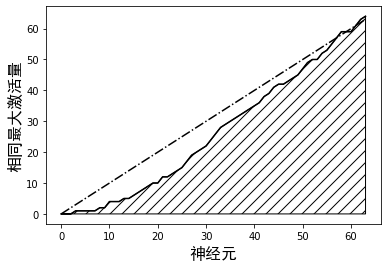

In [24]:
plt.plot([x for x in range(len(stat))],stat, 'k')
plt.plot([x for x in range(len(stat))],[x for x in range(len(stat))], 'k-.')
plt.fill_between([x for x in range(len(stat))], [0 for _ in range(len(stat))],  stat, hatch='//', edgecolor='k', fc='w')
plt.xlabel('神经元',FontProperties=my_font,fontsize=16)
plt.ylabel('相同最大激活量',FontProperties=my_font,fontsize=16)
# plt.savefig('samemax-cifar-resnet.png')
plt.savefig('samemax-olivetti-resnet.png')

In [25]:
neuron_num = 64
TCM = (2*sum(stat)-neuron_num)/(neuron_num*neuron_num)
print(TCM)

0.8125


In [26]:
import copy
new_params = copy.deepcopy(param_values)

In [27]:
mal_pred = []
for neurons in range(64):
    new_params = copy.deepcopy(param_values)
    new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    for batch in iterate_minibatches(X_mal, y_mal, 128):
        inputs, _ = batch
        network.eval()
        outputs = network(torch.from_numpy(inputs).to('cuda')).max(1)[1].cpu().data.numpy()
        out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_mal))
    print(neurons, ":", ok)
    mal_pred.append(ok)

0 : 2048
1 : 2048
2 : 2048
3 : 2048
4 : 2048
5 : 2048
6 : 2048
7 : 2048
8 : 2048
9 : 2048
10 : 2048
11 : 2048
12 : 2048
13 : 2048
14 : 2048
15 : 2048
16 : 2048
17 : 2048
18 : 2048
19 : 2048
20 : 2047
21 : 2046
22 : 2046
23 : 2046
24 : 2046
25 : 2046
26 : 2045
27 : 2045
28 : 2043
29 : 2014
30 : 2025
31 : 2015
32 : 1984
33 : 1922
34 : 1936
35 : 1463
36 : 1458
37 : 1454
38 : 1441
39 : 1429
40 : 1387
41 : 1393
42 : 1406
43 : 1337
44 : 1334
45 : 1307
46 : 1272
47 : 1290
48 : 1249
49 : 1249
50 : 1239
51 : 1244
52 : 1167
53 : 1153
54 : 1126
55 : 1136
56 : 1084
57 : 1163
58 : 1167
59 : 1135
60 : 1128
61 : 1082
62 : 325
63 : 269


In [28]:
clean_train_pred = []
for neurons in range(64):
    new_params = copy.deepcopy(param_values)
    new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for batch in iterate_minibatches(X_train, y_train, 40):
            inputs, _ = batch
            network.eval()
            outputs = network(torch.from_numpy(inputs).to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_train))
    print(neurons, ':', ok, "\t", end="")
    clean_train_pred.append(ok)

0 : 560 	1 : 560 	2 : 560 	3 : 560 	4 : 560 	5 : 560 	6 : 560 	7 : 560 	8 : 560 	9 : 560 	10 : 560 	11 : 560 	12 : 560 	13 : 560 	14 : 560 	15 : 560 	16 : 560 	17 : 560 	18 : 560 	19 : 560 	20 : 560 	21 : 559 	22 : 559 	23 : 559 	24 : 559 	25 : 560 	26 : 560 	27 : 559 	28 : 559 	29 : 559 	30 : 559 	31 : 560 	32 : 560 	33 : 560 	34 : 558 	35 : 544 	36 : 543 	37 : 538 	38 : 538 	39 : 540 	40 : 522 	41 : 525 	42 : 525 	43 : 514 	44 : 505 	45 : 494 	46 : 471 	47 : 469 	48 : 416 	49 : 402 	50 : 376 	51 : 347 	52 : 338 	53 : 312 	54 : 299 	55 : 266 	56 : 190 	57 : 160 	58 : 127 	59 : 101 	60 : 94 	61 : 58 	62 : 31 	63 : 22 	

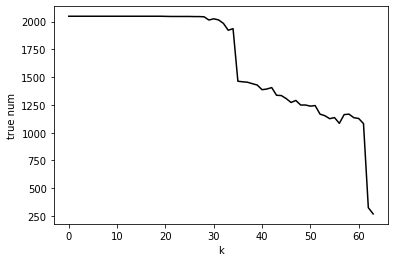

In [29]:
import pandas as pd
df_mal = pd.DataFrame(mal_pred)
df_mal.columns = ['mal']
#plt.plot(arr)
plt.plot([x for x in range(len(df_mal))],df_mal['mal'], "-k")
plt.xlabel('k')
plt.ylabel('true num') 
# plt.savefig('prune-mal-1.png')
plt.show()

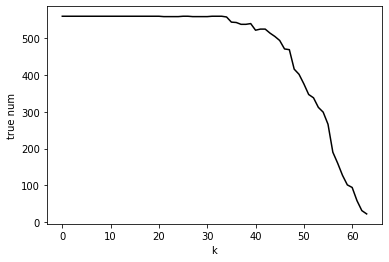

In [30]:
df_train_clean = pd.DataFrame(clean_train_pred)
df_train_clean.columns = ['train_clean']
#plt.plot(arr)
plt.plot([x for x in range(len(df_train_clean))],df_train_clean['train_clean'], "-k")
plt.xlabel('k')
plt.ylabel('true num')
# plt.savefig('prune-clean.png')
plt.show()

In [31]:
clean_test_pred = []
for neurons in range(64):
    new_params = copy.deepcopy(param_values)
    new_params['fc_out.weight'][:,seq_sort_clean[:neurons]] = torch.from_numpy(np.zeros([n_out, neurons])).float().cuda()
    network.load_state_dict(new_params)

    out_list = []
    with torch.no_grad():
        for batch in iterate_minibatches(X_test, y_test, 40):
            inputs, _ = batch
            network.eval()
            outputs = network(torch.from_numpy(inputs).to('cuda')).max(1)[1].cpu().data.numpy()
            out_list.extend(list(outputs))
    np_out_list = np.array(out_list)
    ok = np.sum(np.equal(np_out_list, y_test))
    print(neurons, ':', ok)
    clean_test_pred.append(ok)

0 : 107
1 : 107
2 : 107
3 : 107
4 : 107
5 : 107
6 : 107
7 : 107
8 : 107
9 : 107
10 : 107
11 : 107
12 : 107
13 : 107
14 : 107
15 : 107
16 : 107
17 : 107
18 : 107
19 : 106
20 : 106
21 : 106
22 : 106
23 : 106
24 : 106
25 : 106
26 : 106
27 : 106
28 : 107
29 : 107
30 : 107
31 : 107
32 : 107
33 : 107
34 : 103
35 : 96
36 : 95
37 : 96
38 : 96
39 : 96
40 : 90
41 : 89
42 : 90
43 : 90
44 : 91
45 : 88
46 : 81
47 : 80
48 : 71
49 : 66
50 : 57
51 : 59
52 : 55
53 : 53
54 : 48
55 : 43
56 : 35
57 : 28
58 : 22
59 : 17
60 : 21
61 : 11
62 : 6
63 : 9


In [32]:
df_test = pd.DataFrame(clean_test_pred)

In [33]:
df = df_train_clean.copy()
df['mal'] = df_mal.copy()
df['test_clean'] = df_test.copy()

In [34]:
df['train_clean'] = df['train_clean']/len(X_train)
df['mal'] = df['mal']/len(X_mal)
df['test_clean'] = df['test_clean']/len(X_test)

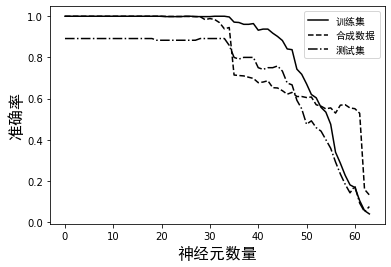

In [36]:
plt.plot([x for x in range(len(df['train_clean']))],df['train_clean'], "-k", label='训练集')
plt.plot([x for x in range(len(df['mal']))],df['mal'], "--k", label='合成数据')
plt.plot([x for x in range(len(df['test_clean']))],df['test_clean'], "-.k", label='测试集')
plt.xlabel('神经元数量',FontProperties=my_font,fontsize=16)
plt.ylabel('准确率',FontProperties=my_font,fontsize=16)
plt.legend(prop=my_font)
plt.savefig('prune-accuracy-olivetti-resnet.png')

In [37]:
torch.save(new_params, 'prune-model-olivetti-resnet.ckpt')